# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:wisig-oracle.run1",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10",
                "1-12",
                "1-14",
                "1-16",
                "1-18",
                "1-19",
                "1-8",
                "10-11",
                "10-17",
                "10-4",
                "10-7",
                "11-1",
                "11-10",
                "11-19",
                "11-20",
                "11-4",
                "11-7",
                "12-19",
                "12-20",
                "12-7",
                "13-14",
                "13-18",
                "13-19",
                "13-20",
                "13-3",
                "13-7",
                "14-10",
                "14-11",
                "14-12",
                "14-13",
                "14-14",
                "14-19",
                "14-20",
                "14-7",
                "14-8",
                "14-9",
                "15-1",
                "15-19",
                "15-6",
                "16-1",
                "16-16",
                "16-19",
                "16-20",
                "17-10",
                "17-11",
                "18-1",
                "18-10",
                "18-11",
                "18-12",
                "18-13",
                "18-14",
                "18-15",
                "18-16",
                "18-17",
                "18-19",
                "18-2",
                "18-20",
                "18-4",
                "18-5",
                "18-7",
                "18-8",
                "18-9",
                "19-1",
                "19-10",
                "19-11",
                "19-12",
                "19-13",
                "19-14",
                "19-15",
                "19-19",
                "19-2",
                "19-20",
                "19-3",
                "19-4",
                "19-6",
                "19-7",
                "19-8",
                "19-9",
                "2-1",
                "2-13",
                "2-15",
                "2-3",
                "2-4",
                "2-5",
                "2-6",
                "2-7",
                "2-8",
                "20-1",
                "20-12",
                "20-14",
                "20-15",
                "20-16",
                "20-18",
                "20-19",
                "20-20",
                "20-3",
                "20-4",
                "20-5",
                "20-7",
                "20-8",
                "3-1",
                "3-13",
                "3-18",
                "3-2",
                "3-8",
                "4-1",
                "4-10",
                "4-11",
                "5-1",
                "5-5",
                "6-1",
                "6-15",
                "6-6",
                "7-10",
                "7-11",
                "7-12",
                "7-13",
                "7-14",
                "7-7",
                "7-8",
                "7-9",
                "8-1",
                "8-13",
                "8-14",
                "8-18",
                "8-20",
                "8-3",
                "8-8",
                "9-1",
                "9-7",
            ],
            "domains": [1, 2, 3, 4],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/root/csc500-main/datasets/wisig.node3-19.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "Wisig_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 10000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": [],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1",
        },
    ],
    "dataset_seed": 154325,
    "seed": 154325,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run120', 'ORACLE.run18', 'ORACLE.run114', 'ORACLE.run138', 'ORACLE.run126', 'ORACLE.run150', 'ORACLE.run144', 'ORACLE.run132'}


{'Wisig_4', 'Wisig_3', 'Wisig_2', 'Wisig_1'}


tensor([[[ 3.9064e-03, -2.3194e-03, -4.0895e-03,  ..., -4.5778e-04,
           2.8687e-03, -7.5686e-03],
         [ 4.2421e-03,  1.1902e-03,  2.1973e-03,  ...,  4.9440e-03,
          -9.1556e-05, -8.5757e-03]],

        [[ 7.5991e-03,  6.4699e-03, -5.1881e-03,  ...,  2.2584e-03,
           2.7467e-04, -6.9277e-03],
         [ 1.0376e-03, -1.0376e-03,  6.4699e-03,  ...,  8.5452e-04,
          -3.5707e-03, -3.6317e-03]],

        [[-2.7772e-03, -1.8006e-03, -3.2044e-03,  ..., -1.9227e-03,
           1.9837e-03,  5.3407e-03],
         [ 6.5310e-03, -1.3123e-03, -3.9979e-03,  ...,  6.1037e-03,
          -6.1037e-04, -3.3265e-03]],

        ...,

        [[ 3.7843e-03, -2.4720e-03, -1.0041e-02,  ..., -1.2818e-03,
           3.6317e-03,  3.1739e-03],
         [-3.9979e-03, -6.4089e-04,  4.6083e-03,  ...,  5.6764e-03,
           4.9745e-03, -8.3316e-03]],

        [[-2.2279e-03,  7.9348e-04, -7.0193e-04,  ..., -4.6693e-03,
          -3.6927e-03, -3.7843e-03],
         [-4.5778e-03,  8.2400e-0

In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 33600], examples_per_second: 6.6427, train_label_loss: 2.7092, 


epoch: 1, [batch: 3360 / 33600], examples_per_second: 2964.2433, train_label_loss: 1.1881, 


epoch: 1, [batch: 6720 / 33600], examples_per_second: 2972.9914, train_label_loss: 0.6692, 


epoch: 1, [batch: 10080 / 33600], examples_per_second: 2953.7811, train_label_loss: 0.8758, 


epoch: 1, [batch: 13440 / 33600], examples_per_second: 2942.5136, train_label_loss: 0.4661, 


epoch: 1, [batch: 16800 / 33600], examples_per_second: 2946.0467, train_label_loss: 0.5840, 


epoch: 1, [batch: 20160 / 33600], examples_per_second: 3044.2265, train_label_loss: 0.4137, 


epoch: 1, [batch: 23520 / 33600], examples_per_second: 3419.5398, train_label_loss: 0.5932, 


epoch: 1, [batch: 26880 / 33600], examples_per_second: 3320.3069, train_label_loss: 0.3773, 


epoch: 1, [batch: 30240 / 33600], examples_per_second: 3043.8907, train_label_loss: 0.4046, 


epoch: 1, source_val_acc_label: 0.7813, target_val_acc_label: 0.7821, source_val_label_loss: 0.7662, target_val_label_loss: 265.3663, 


New best


epoch: 2, [batch: 1 / 33600], examples_per_second: 0.8547, train_label_loss: 0.3865, 


epoch: 2, [batch: 3360 / 33600], examples_per_second: 2990.4851, train_label_loss: 0.5033, 


epoch: 2, [batch: 6720 / 33600], examples_per_second: 2974.2598, train_label_loss: 0.2613, 


epoch: 2, [batch: 10080 / 33600], examples_per_second: 2985.0607, train_label_loss: 0.3245, 


epoch: 2, [batch: 13440 / 33600], examples_per_second: 2998.8914, train_label_loss: 0.2505, 


epoch: 2, [batch: 16800 / 33600], examples_per_second: 3018.2887, train_label_loss: 0.1614, 


epoch: 2, [batch: 20160 / 33600], examples_per_second: 3006.1533, train_label_loss: 0.2311, 


epoch: 2, [batch: 23520 / 33600], examples_per_second: 3337.3817, train_label_loss: 0.3060, 


epoch: 2, [batch: 26880 / 33600], examples_per_second: 3443.6628, train_label_loss: 0.5222, 


epoch: 2, [batch: 30240 / 33600], examples_per_second: 3009.3225, train_label_loss: 0.3255, 


epoch: 2, source_val_acc_label: 0.8516, target_val_acc_label: 0.8360, source_val_label_loss: 0.4055, target_val_label_loss: 77.2801, 


New best


epoch: 3, [batch: 1 / 33600], examples_per_second: 0.8763, train_label_loss: 0.7251, 


epoch: 3, [batch: 3360 / 33600], examples_per_second: 2991.6753, train_label_loss: 0.2779, 


epoch: 3, [batch: 6720 / 33600], examples_per_second: 3000.9822, train_label_loss: 0.4423, 


epoch: 3, [batch: 10080 / 33600], examples_per_second: 3014.6343, train_label_loss: 0.4547, 


epoch: 3, [batch: 13440 / 33600], examples_per_second: 2991.2552, train_label_loss: 0.2024, 


epoch: 3, [batch: 16800 / 33600], examples_per_second: 2978.6930, train_label_loss: 0.4777, 


epoch: 3, [batch: 20160 / 33600], examples_per_second: 2973.6242, train_label_loss: 0.4768, 


epoch: 3, [batch: 23520 / 33600], examples_per_second: 3317.2396, train_label_loss: 0.4352, 


epoch: 3, [batch: 26880 / 33600], examples_per_second: 3527.0295, train_label_loss: 0.3873, 


epoch: 3, [batch: 30240 / 33600], examples_per_second: 2982.8343, train_label_loss: 0.1555, 


epoch: 3, source_val_acc_label: 0.8650, target_val_acc_label: 0.8423, source_val_label_loss: 0.3831, target_val_label_loss: 92.6444, 


New best


epoch: 4, [batch: 1 / 33600], examples_per_second: 0.8667, train_label_loss: 0.3054, 


epoch: 4, [batch: 3360 / 33600], examples_per_second: 2981.1539, train_label_loss: 0.7799, 


epoch: 4, [batch: 6720 / 33600], examples_per_second: 2966.9054, train_label_loss: 0.3944, 


epoch: 4, [batch: 10080 / 33600], examples_per_second: 3032.9138, train_label_loss: 0.1445, 


epoch: 4, [batch: 13440 / 33600], examples_per_second: 2935.6321, train_label_loss: 0.2116, 


epoch: 4, [batch: 16800 / 33600], examples_per_second: 2970.8491, train_label_loss: 0.4621, 


epoch: 4, [batch: 20160 / 33600], examples_per_second: 2991.2826, train_label_loss: 0.7511, 


epoch: 4, [batch: 23520 / 33600], examples_per_second: 3256.3482, train_label_loss: 0.6155, 


epoch: 4, [batch: 26880 / 33600], examples_per_second: 3581.2608, train_label_loss: 0.3409, 


epoch: 4, [batch: 30240 / 33600], examples_per_second: 3091.6187, train_label_loss: 0.4441, 


epoch: 4, source_val_acc_label: 0.8705, target_val_acc_label: 0.8430, source_val_label_loss: 0.3590, target_val_label_loss: 103.9061, 


New best


epoch: 5, [batch: 1 / 33600], examples_per_second: 0.8458, train_label_loss: 0.5829, 


epoch: 5, [batch: 3360 / 33600], examples_per_second: 2999.7457, train_label_loss: 0.4689, 


epoch: 5, [batch: 6720 / 33600], examples_per_second: 2987.8404, train_label_loss: 0.1609, 


epoch: 5, [batch: 10080 / 33600], examples_per_second: 2992.3490, train_label_loss: 0.6900, 


epoch: 5, [batch: 13440 / 33600], examples_per_second: 2992.9296, train_label_loss: 0.3021, 


epoch: 5, [batch: 16800 / 33600], examples_per_second: 3003.9634, train_label_loss: 0.1676, 


epoch: 5, [batch: 20160 / 33600], examples_per_second: 2978.0068, train_label_loss: 0.1826, 


epoch: 5, [batch: 23520 / 33600], examples_per_second: 3150.0198, train_label_loss: 0.1952, 


epoch: 5, [batch: 26880 / 33600], examples_per_second: 3478.4803, train_label_loss: 0.1807, 


epoch: 5, [batch: 30240 / 33600], examples_per_second: 3183.2686, train_label_loss: 0.2737, 


epoch: 5, source_val_acc_label: 0.8791, target_val_acc_label: 0.8447, source_val_label_loss: 0.3572, target_val_label_loss: 148.3987, 


New best


epoch: 6, [batch: 1 / 33600], examples_per_second: 0.8290, train_label_loss: 0.2406, 


epoch: 6, [batch: 3360 / 33600], examples_per_second: 3013.0259, train_label_loss: 0.2366, 


epoch: 6, [batch: 6720 / 33600], examples_per_second: 2983.4850, train_label_loss: 0.0541, 


epoch: 6, [batch: 10080 / 33600], examples_per_second: 2989.4778, train_label_loss: 0.7316, 


epoch: 6, [batch: 13440 / 33600], examples_per_second: 2975.1302, train_label_loss: 0.3507, 


epoch: 6, [batch: 16800 / 33600], examples_per_second: 2993.3530, train_label_loss: 0.3383, 


epoch: 6, [batch: 20160 / 33600], examples_per_second: 3015.5482, train_label_loss: 0.0631, 


epoch: 6, [batch: 23520 / 33600], examples_per_second: 3081.4011, train_label_loss: 0.1755, 


epoch: 6, [batch: 26880 / 33600], examples_per_second: 3436.1593, train_label_loss: 0.3878, 


epoch: 6, [batch: 30240 / 33600], examples_per_second: 3289.2350, train_label_loss: 0.1773, 


epoch: 6, source_val_acc_label: 0.8764, target_val_acc_label: 0.8460, source_val_label_loss: 0.3461, target_val_label_loss: 157.9869, 


New best


epoch: 7, [batch: 1 / 33600], examples_per_second: 0.8146, train_label_loss: 0.5212, 


epoch: 7, [batch: 3360 / 33600], examples_per_second: 2981.0054, train_label_loss: 0.3380, 


epoch: 7, [batch: 6720 / 33600], examples_per_second: 2987.8930, train_label_loss: 0.0521, 


epoch: 7, [batch: 10080 / 33600], examples_per_second: 2980.9735, train_label_loss: 0.1679, 


epoch: 7, [batch: 13440 / 33600], examples_per_second: 2973.1641, train_label_loss: 0.2258, 


epoch: 7, [batch: 16800 / 33600], examples_per_second: 2998.5883, train_label_loss: 0.2467, 


epoch: 7, [batch: 20160 / 33600], examples_per_second: 2968.8569, train_label_loss: 0.3225, 


epoch: 7, [batch: 23520 / 33600], examples_per_second: 3074.7256, train_label_loss: 0.1124, 


epoch: 7, [batch: 26880 / 33600], examples_per_second: 3404.4743, train_label_loss: 0.2321, 


epoch: 7, [batch: 30240 / 33600], examples_per_second: 3312.5192, train_label_loss: 0.2010, 


epoch: 7, source_val_acc_label: 0.8780, target_val_acc_label: 0.8654, source_val_label_loss: 0.3462, target_val_label_loss: 112.5109, 


New best


epoch: 8, [batch: 1 / 33600], examples_per_second: 0.8148, train_label_loss: 0.2188, 


epoch: 8, [batch: 3360 / 33600], examples_per_second: 2994.9843, train_label_loss: 0.3728, 


epoch: 8, [batch: 6720 / 33600], examples_per_second: 2980.9737, train_label_loss: 0.1942, 


epoch: 8, [batch: 10080 / 33600], examples_per_second: 2992.4904, train_label_loss: 0.0879, 


epoch: 8, [batch: 13440 / 33600], examples_per_second: 2973.9939, train_label_loss: 0.2873, 


epoch: 8, [batch: 16800 / 33600], examples_per_second: 2983.0268, train_label_loss: 0.2889, 


epoch: 8, [batch: 20160 / 33600], examples_per_second: 2980.5884, train_label_loss: 0.2181, 


epoch: 8, [batch: 23520 / 33600], examples_per_second: 3058.0028, train_label_loss: 0.4437, 


epoch: 8, [batch: 26880 / 33600], examples_per_second: 3429.0802, train_label_loss: 0.1873, 


epoch: 8, [batch: 30240 / 33600], examples_per_second: 3353.2958, train_label_loss: 0.2931, 


epoch: 8, source_val_acc_label: 0.8800, target_val_acc_label: 0.8550, source_val_label_loss: 0.3385, target_val_label_loss: 152.2556, 


epoch: 9, [batch: 1 / 33600], examples_per_second: 0.7954, train_label_loss: 0.0331, 


epoch: 9, [batch: 3360 / 33600], examples_per_second: 3446.0786, train_label_loss: 0.1333, 


epoch: 9, [batch: 6720 / 33600], examples_per_second: 3458.8254, train_label_loss: 0.1973, 


epoch: 9, [batch: 10080 / 33600], examples_per_second: 3474.1805, train_label_loss: 0.2460, 


epoch: 9, [batch: 13440 / 33600], examples_per_second: 3346.1526, train_label_loss: 0.1617, 


epoch: 9, [batch: 16800 / 33600], examples_per_second: 3640.0753, train_label_loss: 0.4339, 


epoch: 9, [batch: 20160 / 33600], examples_per_second: 3932.8228, train_label_loss: 0.1896, 


epoch: 9, [batch: 23520 / 33600], examples_per_second: 4010.8182, train_label_loss: 0.1584, 


epoch: 9, [batch: 26880 / 33600], examples_per_second: 4518.6748, train_label_loss: 0.4281, 


epoch: 9, [batch: 30240 / 33600], examples_per_second: 4185.0372, train_label_loss: 0.0783, 


epoch: 9, source_val_acc_label: 0.8808, target_val_acc_label: 0.8635, source_val_label_loss: 0.3342, target_val_label_loss: 142.3462, 


epoch: 10, [batch: 1 / 33600], examples_per_second: 1.0120, train_label_loss: 0.1019, 


epoch: 10, [batch: 3360 / 33600], examples_per_second: 3001.0768, train_label_loss: 0.1074, 


epoch: 10, [batch: 6720 / 33600], examples_per_second: 2973.5596, train_label_loss: 0.2620, 


epoch: 10, [batch: 10080 / 33600], examples_per_second: 3369.0693, train_label_loss: 0.2413, 


epoch: 10, [batch: 13440 / 33600], examples_per_second: 3209.6422, train_label_loss: 0.3870, 


epoch: 10, [batch: 16800 / 33600], examples_per_second: 3013.7539, train_label_loss: 0.2148, 


epoch: 10, [batch: 20160 / 33600], examples_per_second: 3188.9791, train_label_loss: 0.0468, 


epoch: 10, [batch: 23520 / 33600], examples_per_second: 3472.5867, train_label_loss: 0.3389, 


epoch: 10, [batch: 26880 / 33600], examples_per_second: 3405.9151, train_label_loss: 0.2168, 


epoch: 10, [batch: 30240 / 33600], examples_per_second: 3425.2969, train_label_loss: 0.2262, 


epoch: 10, source_val_acc_label: 0.8827, target_val_acc_label: 0.8528, source_val_label_loss: 0.3413, target_val_label_loss: 193.0942, 


epoch: 11, [batch: 1 / 33600], examples_per_second: 0.9311, train_label_loss: 0.2262, 


epoch: 11, [batch: 3360 / 33600], examples_per_second: 3445.3741, train_label_loss: 0.3241, 


epoch: 11, [batch: 6720 / 33600], examples_per_second: 4041.9506, train_label_loss: 0.0991, 


epoch: 11, [batch: 10080 / 33600], examples_per_second: 4010.1110, train_label_loss: 0.0641, 


epoch: 11, [batch: 13440 / 33600], examples_per_second: 3945.1319, train_label_loss: 0.3054, 


epoch: 11, [batch: 16800 / 33600], examples_per_second: 4305.1131, train_label_loss: 0.2713, 


epoch: 11, [batch: 20160 / 33600], examples_per_second: 4532.8519, train_label_loss: 0.2217, 


epoch: 11, [batch: 23520 / 33600], examples_per_second: 4362.6842, train_label_loss: 0.1287, 


epoch: 11, [batch: 26880 / 33600], examples_per_second: 4286.3858, train_label_loss: 0.0717, 


epoch: 11, [batch: 30240 / 33600], examples_per_second: 3795.9047, train_label_loss: 0.0745, 


epoch: 11, source_val_acc_label: 0.8856, target_val_acc_label: 0.8567, source_val_label_loss: 0.3302, target_val_label_loss: 191.8676, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

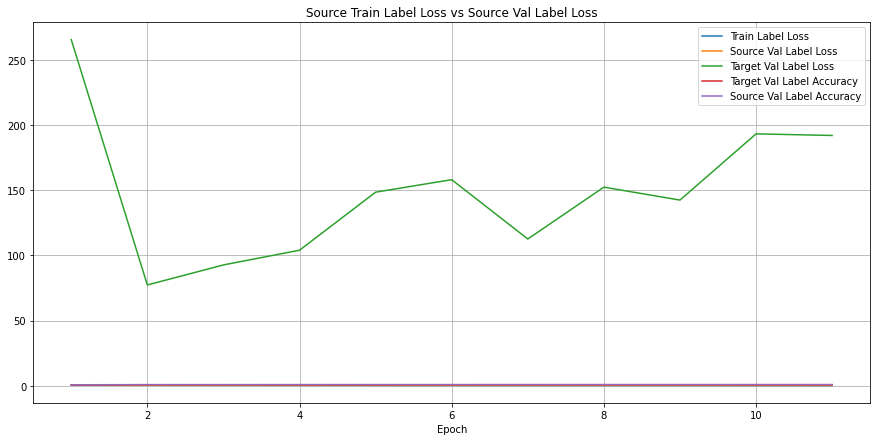

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

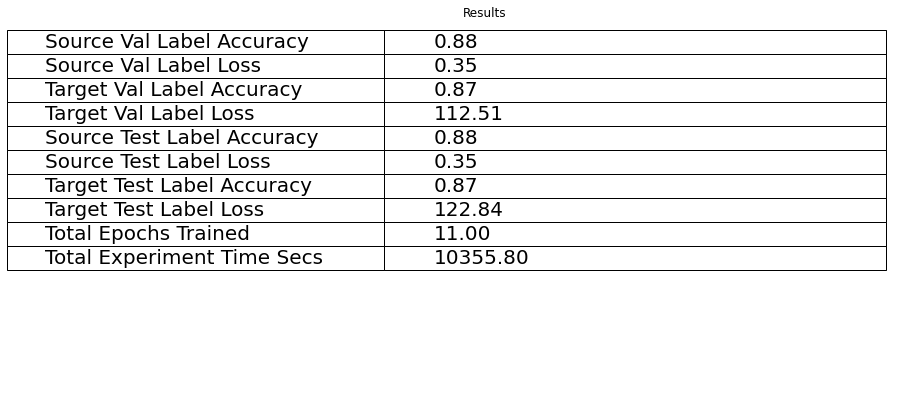

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

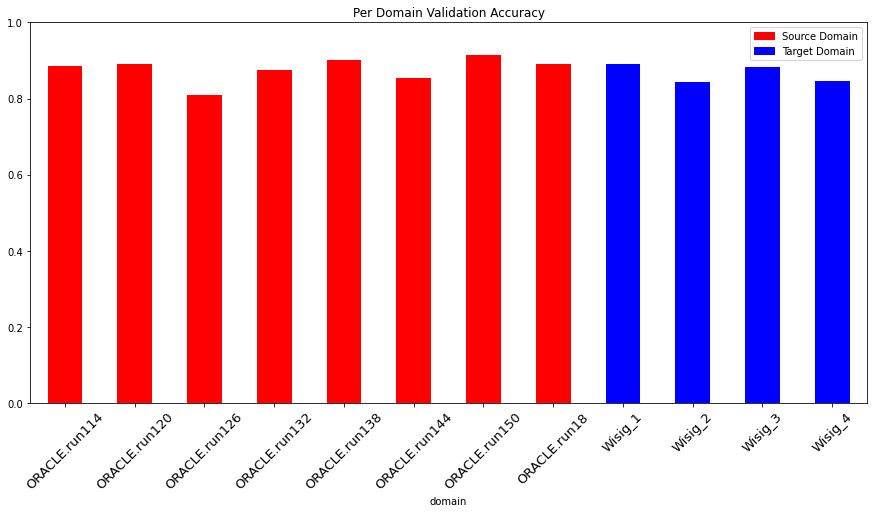

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.8782161458333333 Target Test Label Accuracy: 0.866015625
Source Val Label Accuracy: 0.8779557291666666 Target Val Label Accuracy: 0.8653897136797455


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:wisig-oracle.run1", "parameters": {"experiment_name": "tl_1v2:wisig-oracle.run1", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}, {"class": "ReL